In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mylibrary.nnlib as tnn
import mylibrary.datasets as datasets

import copy

## Loading the dataset

In [2]:
mnist = datasets.MNIST()
train_data, train_label_, test_data, test_label_ = mnist.load()

train_data = train_data / 255.
test_data = test_data / 255.

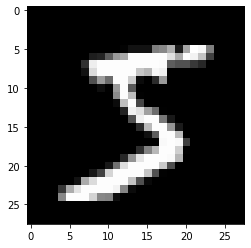

In [3]:
plt.imshow(train_data[0].reshape(28,28), cmap='gray')

## Making Class for Soft But Hard Decision Tree - Dynamic Building/End2End

In [28]:
class LeafNode(object):
    
    def __init__(self, parent, constant=None):
        self.parent = parent
        self.constant = tnn.BiasLayer(self.parent.output_dim,
                                      bias=copy.deepcopy(constant),
                                      optimizer=self.parent.optimizer)
        self.error = None
        self.mask = None
        self.m = None
        
    def forward(self, inputs, mask):
        self.mask = mask
        self.m = np.count_nonzero(mask)
        out = np.zeros(shape=(inputs.shape[0], self.parent.output_dim))
        return self.constant.forward(out)*self.mask
    
    def backward(self, del_outputs):
        del_out = del_outputs*self.mask
        self.constant.backward(del_out)

        if self.m==0:return del_outputs
        
        self.error = (del_out**2).sum()/self.m
        return del_outputs
    
    def update(self):
        self.constant.update()
        
    def get_maximum_error_node(self):
        return self
    
    def print_tree(self, depth):
        print(f"{'|     '*depth}Leaf:({depth})")
        return
    
class DecisionNode(object):
    
    def __init__(self, input_dim, output_dim, optimizer):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.optimizer = optimizer
        
        self.node0 = None
        self.node1 = None
        self.linear = tnn.LinearLayer(input_dim, output_dim, optimizer=optimizer)
        self.linear.weights *= 0
        self.sigmoid = tnn.Sigmoid()
        
        self.mask = None
        self.out0 = None
        self.out1 = None
        
    def forward(self, inputs, mask=None):
        if mask is None:mask = np.ones(shape=(inputs.shape[0], 1))
        
        self.mask = mask
        
        lout = self.linear.forward(inputs)
        self.sigmoid.forward(lout)
        
        mask = (lout>0).astype(lout.dtype)
        self.out0 = self.node0.forward(inputs, self.mask*mask)
        self.out1 = self.node1.forward(inputs, self.mask*(1-mask))
        
        return self.out0 + self.out1
    
    def backward(self, del_outputs):
        
        self.node0.backward(del_outputs)
        self.node1.backward(del_outputs)
        
        del_out = del_outputs.mean(axis=1, keepdims=True)*self.mask
        self.linear.backward(self.sigmoid.backward(del_out))
        
        return del_outputs
    
    def update(self):
        self.linear.update()
        self.node0.update()
        self.node1.update()
        
    def create_child(self, depth):
        if depth > 1:
            self.node0 = DecisionNode(self.input_dim, self.output_dim, self.optimizer)
            self.node1 = DecisionNode(self.input_dim, self.output_dim, self.optimizer)
            self.node0.create_child(depth-1)
            self.node1.create_child(depth-1)
        else:
            self.node0 = LeafNode(self)
            self.node1 = LeafNode(self)
            
    def get_maximum_error_node(self):
        n0 = self.node0.get_maximum_error_node()
        n1 = self.node1.get_maximum_error_node()
        if n0.error > n1.error:
            return n0
        else:
            return n1
        
    def print_tree(self, depth=0):
        print(f"{'|     '*depth}DN:({depth})")
        self.node0.print_tree(depth+1)
        self.node1.print_tree(depth+1)

In [29]:
def convert_leaf_to_decision_node(node):
    parent = node.parent
    const = copy.deepcopy(node.constant.bias)

    
    dn = DecisionNode(parent.input_dim, parent.output_dim, parent.optimizer)
    dn.node0 = LeafNode(dn, const)
    dn.node1 = LeafNode(dn, const)
    if parent.node0 is node:
        del parent.node0
        parent.node0 = dn
    elif parent.node1 is node:
        del parent.node1
        parent.node1 = dn
    else:
        print(parent.node0, parent.node1, node)
        print("Error occoured -- Problem in Algorithm")
    return

def add_node_to_tree(tree):
    try:
        node = tree.get_maximum_error_node()
        convert_leaf_to_decision_node(node)
    except:
        print("Error occoured while converting leaf node to decision Node")
    return

In [30]:
input_size = 784
output_size = 10

learning_rate = 0.0001
batch_size = 300 #64
EPOCHS = 10

train_label = tnn.Logits.index_to_logit(train_label_)
train_size = len(train_label)

In [59]:
optimizer = tnn.Adam(learning_rate)

# np.random.seed(27)
tree_depth = 1
sdt = DecisionNode(input_size, output_size, optimizer)
sdt.create_child(tree_depth)

In [74]:
accuracy_list = []

for epoch in range(EPOCHS):    
    for index in range(train_size // batch_size):
        
        train_x = train_data[index * batch_size:(index + 1) * batch_size]
        train_y = train_label[index * batch_size:(index + 1) * batch_size]
        
        yout = sdt.forward(train_x)

        dy = tnn.SoftmaxCrossEntropy.del_loss(yout, train_y)
        loss = tnn.SoftmaxCrossEntropy.loss(yout, train_y)

        dx = sdt.backward(dy)

        sdt.update()

        if index % 100 == 0:
            print('\nTRAIN',index, '-> ', loss)

    yout = sdt.forward(train_data)
    outputs = tnn.Logits.logit_to_index(yout)
    correct = (outputs == np.array(train_label_)).sum()

    accuracy = correct / len(train_label_) * 100.
    print('EPOCH = ',epoch,'accuracy = ', accuracy)
    print(correct, '/', len(train_label_))

    yout = sdt.forward(test_data)
    outputs = tnn.Logits.logit_to_index(yout)
    correct = (outputs == np.array(test_label_)).sum()

    accuracy_ = correct / len(test_label_) * 100.
    print('   TEST  ','accuracy = ', accuracy_)
    print(correct, '/', len(test_label_))  
    
    accuracy_list.append((accuracy, accuracy_))


TRAIN 0 ->  8.005781761200524

TRAIN 100 ->  8.005626878001488
EPOCH =  0 accuracy =  11.236666666666666
6742 / 60000
   TEST   accuracy =  11.35
1135 / 10000

TRAIN 0 ->  8.005782233744098

TRAIN 100 ->  8.005626648085226
EPOCH =  1 accuracy =  11.236666666666666
6742 / 60000
   TEST   accuracy =  11.35
1135 / 10000

TRAIN 0 ->  8.005782629547271

TRAIN 100 ->  8.005626455305698
EPOCH =  2 accuracy =  11.236666666666666
6742 / 60000
   TEST   accuracy =  11.35
1135 / 10000

TRAIN 0 ->  8.00578295976659

TRAIN 100 ->  8.005626294331268
EPOCH =  3 accuracy =  11.236666666666666
6742 / 60000
   TEST   accuracy =  11.35
1135 / 10000

TRAIN 0 ->  8.005783234353693

TRAIN 100 ->  8.005626160382032
EPOCH =  4 accuracy =  11.236666666666666
6742 / 60000
   TEST   accuracy =  11.35
1135 / 10000

TRAIN 0 ->  8.005783462044237

TRAIN 100 ->  8.005626049245842
EPOCH =  5 accuracy =  11.236666666666666
6742 / 60000
   TEST   accuracy =  11.35
1135 / 10000

TRAIN 0 ->  8.005783650407706

TRAIN 100

In [75]:
add_node_to_tree(sdt)

Error occoured while converting leaf node to decision Node


In [76]:
sdt.print_tree()

DN:(0)
|     Leaf:(1)
|     DN:(1)
|     |     Leaf:(2)
|     |     Leaf:(2)


In [66]:
yout.max(axis=0)

array([0.09639114, 0.1071764 , 0.09708046, 0.09919827, 0.09512402,
       0.08920402, 0.09627536, 0.10118588, 0.09577935, 0.09655597])

In [51]:
sdt.node0.node0.node0.error

0.09003087601802529

In [52]:
sdt.node0.node0.node1.error

0.09999999999800001

In [53]:
sdt.node0.node1.node0.error

In [54]:
sdt.node0.node1.node1.error

0.09999999999800001

In [55]:
sdt.node1.node0.node0.error

In [56]:
sdt.node1.node0.node1.error

In [57]:
sdt.node1.node1.node0.error

In [58]:
sdt.node1.node1.node1.error

0.09999999999800001